In [1]:
# Спринт 2/11: 2 спринт. Улучшение baseline-модели → Тема 3/6: Feature engineering — генерация и отбор признаков → Урок 10/11

#Методы отбора признаков. Практика
#Вернёмся к модели «Космолайна», предсказывающей отток клиентов. Вы уже обучили её базовую версию, а также вариант модели с
# дополнительными признаками. Чтобы улучшить качество предсказаний модели и увеличить скорость её работы в продакшене, 
# избавьтесь от лишних признаков, используя методы, изученные в предыдущем уроке.

In [2]:
import os

import psycopg
import pandas as pd
import mlflow
from catboost import CatBoostClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [50]:
TABLE_NAME = "users_churn" # ваш код здесь #
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'churn_kruglikovAlex' # ваш код здесь #
RUN_NAME = "feature_selection"
REGISTRY_MODEL_NAME = 'churn_model_kruglikovAlex_b2c' # ваш код здесь #
FS_ASSETS = "../fs_assets" 

In [4]:
# Далее загрузите данные для задачи оттока из таблицы в базе данных PostgreSQL и положите их в переменную df. 
# После этого разделите данные на обучающую, валидационную и тестовую выборки или используйте уже разделённые 
# данные. Напомним, что отбор признаков важно проводить на обучающем наборе данных, чтобы исключить переобучение.
# Для отбора признаков используйте библиотеку mlxtend и методы Sequential Forward Selection (SFS) и Sequential Backward Selection (SBS).

In [5]:
from dotenv import load_dotenv

In [6]:
# подгружаем .env
load_dotenv()

# загрузка данных для обучения модели
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

In [7]:
connection.update(postgres_credentials)

import psycopg

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

In [8]:
df.head()

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,28173,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,...,No,No,No,No,Female,0,Yes,No,None,0
1,28174,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,...,Yes,No,No,No,Male,0,No,No,No,0
2,28175,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,...,No,No,No,No,Male,0,No,No,No,1
3,28176,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,...,Yes,Yes,No,No,Male,0,No,No,None,0
4,28177,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,...,No,No,No,No,Female,0,No,No,No,1


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df.drop(columns='target')

In [11]:
X.head()

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,28173,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,...,Yes,No,No,No,No,Female,0,Yes,No,None
1,28174,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,...,No,Yes,No,No,No,Male,0,No,No,No
2,28175,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,...,Yes,No,No,No,No,Male,0,No,No,No
3,28176,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,...,No,Yes,Yes,No,No,Male,0,No,No,None
4,28177,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,...,No,No,No,No,No,Female,0,No,No,No


In [12]:
df = pd.read_csv('/home/mle-user/mle_projects/mle-dvc/data/initial_data.csv')
df.head()

,id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,7020,2020-01-01,NaN,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Female,0,Yes,No,No,0
1,7021,2017-04-01,NaN,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,0
2,7022,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,1
3,7023,2016-05-01,NaN,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,No,0
4,7024,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,1


In [13]:
cat_features = df.select_dtypes(include='object')
potential_binary_features = cat_features.nunique() == 2

In [14]:
binary_cat_features = cat_features[potential_binary_features[potential_binary_features].index]
other_cat_features = cat_features[potential_binary_features[~potential_binary_features].index]
num_features = df.select_dtypes(['float'])

In [15]:
binary_cols = binary_cat_features.columns.tolist()
non_binary_cat_cols = other_cat_features.columns.tolist()
num_cols = num_features.columns.tolist()

In [16]:
non_binary_cat_cols.append('senior_citizen')

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [18]:
preprocessor = ColumnTransformer(
    [
        ('binary', OneHotEncoder(drop='if_binary'), binary_cols),
        ('cat', CatBoostEncoder(return_df=False), non_binary_cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [19]:
pipeline = Pipeline(
    [
        ('preprocessor', preprocessor)
    ]
)

In [22]:
X_transf = preprocessor.fit_transform(df, df['target'])

In [23]:
X_transf

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
        -1.16615561, -0.99837224],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
        -0.26415426, -0.17728384],
       [ 1.        ,  0.        ,  1.        , ...,  0.        ,
        -0.36733522, -0.96380056],
       ...,
       [ 1.        ,  0.        ,  1.        , ...,  0.        ,
        -1.17447666, -0.85858433],
       [ 1.        ,  1.        ,  0.        , ...,  1.        ,
         0.31665473, -0.87617924],
       [ 1.        ,  1.        ,  1.        , ...,  0.        ,
         1.35678545,  2.01048969]])

In [24]:
X = pd.DataFrame(X_transf, columns=preprocessor.get_feature_names_out())

In [25]:
X.shape

(7019, 19)

In [26]:
cat_features = [
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
]
num_features = ["monthly_charges", "total_charges"]

features = cat_features + num_features

In [27]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, df['target'], test_size=0.2, random_state=42)

In [28]:
X_train.head()

,paperless_billing_Yes,internet_service_Fiber optic,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,gender_Male,partner_Yes,dependents_Yes,multiple_lines_Yes,begin_date,end_date,type,payment_method,senior_citizen,monthly_charges,total_charges
1452,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.217695,0.992185,0.431043,0.473575,0.0,1.168730,-0.333916
3269,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.142396,0.000110,0.107902,0.137051,0.0,-0.255833,-0.383102
5267,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.425978,0.997976,0.420764,0.451926,1.0,-0.638601,-0.924129
1323,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.022119,0.000272,0.102041,0.185432,0.0,-0.453874,-0.061559
5189,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.291131,0.000069,0.023563,0.161636,0.0,0.023754,0.010057


In [29]:
y_train.head()

1452    1
3269    0
5267    1
1323    0
5189    0
Name: target, dtype: int64

In [30]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf

RandomForestClassifier(n_estimators=300, random_state=42)

In [33]:
# Инициализация Sequential Feature Selector для backward selection
sfs = SFS(rf,
          k_features=10, 
          forward=True, 
          floating=False, 
          scoring='roc_auc', 
          cv=4, 
          n_jobs=-1)

In [34]:
sfs

SequentialFeatureSelector(cv=4,
                          estimator=RandomForestClassifier(n_estimators=300,
                                                           random_state=42),
                          k_features=10, n_jobs=-1, scoring='roc_auc')

In [35]:
# Инициализация Sequential Feature Selector для backward selection
sbs = SFS(rf,
          k_features=10, 
          forward=False, 
          floating=False, 
          scoring='roc_auc', 
          cv=4, 
          n_jobs=-1)

In [36]:
sbs

SequentialFeatureSelector(cv=4,
                          estimator=RandomForestClassifier(n_estimators=300,
                                                           random_state=42),
                          forward=False, k_features=10, n_jobs=-1,
                          scoring='roc_auc')

In [37]:
sfs_features = sfs.fit(X_train, y_train)

/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73

In [38]:
sbs_features = sbs.fit(X_train, y_train)

/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73

In [40]:
# Выбор признаков с помощью SFS
top_sfs = sfs.k_feature_names_ # ваш код здесь #

In [41]:
# Выбор признаков с помощью SFS
top_sbs = sbs.k_feature_names_ # ваш код здесь #

In [42]:
top_sfs

('paperless_billing_Yes',
 'internet_service_Fiber optic',
 'online_security_Yes',
 'online_backup_Yes',
 'device_protection_Yes',
 'tech_support_Yes',
 'streaming_tv_Yes',
 'streaming_movies_Yes',
 'gender_Male',
 'end_date')

In [43]:
print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=10)
CV Score:
1.0


In [44]:
print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sbs.k_score_)


Sequential Forward Selection (k=10)
CV Score:
1.0


In [47]:
# Отбор признаков — тоже исследование, и его результаты важно сохранять. 
# После того как вы запустили sfs.fit() или sbs.fit(), на выходе получаются объекты sfs_df и sbs_df, 
# из которых просто получить таблицу с результатами отбора. Сделать это можно так: 

In [45]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 

In [48]:
# Получившийся датафрейм показывает информацию об отборе признаков:

In [46]:
sfs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(13,)","[1.0, 1.0, 1.0, 1.0]",1.0,"(end_date,)",0.0,0.0,0.0
2,"(0, 13)","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, end_date)",0.0,0.0,0.0
3,"(0, 1, 13)","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
4,"(0, 1, 2, 13)","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
5,"(0, 1, 2, 3, 13)","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
6,"(0, 1, 2, 3, 4, 13)","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
7,"(0, 1, 2, 3, 4, 5, 13)","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
8,"(0, 1, 2, 3, 4, 5, 6, 13)","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
9,"(0, 1, 2, 3, 4, 5, 6, 7, 13)","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 13)","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0


In [ ]:
# Где:
# - feature_idx — кортеж индексов отобранных признаков.
# - cv_scores — список индивидуальных оценок на перекрёстной проверке (CV). Информация в следующих столбцах также приводится по перекрёстной проверке.
# - avg_score — средняя оценка.
# - ci_bound — граница доверительного интервала средней оценки.
# - std_dev — стандартное отклонение средней оценки.
# - std_err — стандартная ошибка средней оценки.

In [49]:
sbs_df 

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
19,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
18,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
17,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
16,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
15,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 1.0, 1.0, 0.9999999999999999]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
14,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)","[0.9999999999999999, 0.9999999999999999, 1.0, ...",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
13,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13)","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
12,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13)","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
11,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13)","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 13)","[1.0, 1.0, 1.0, 1.0]",1.0,"(paperless_billing_Yes, internet_service_Fiber...",0.0,0.0,0.0


In [56]:
# save on disk
os.makedirs(FS_ASSETS, exist_ok=True)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv") 

In [57]:
# Постройте графики отбора признаков для методов SFS и SBS и сохраните графики в директорию с артефактами.
# Начнём с SFS. 

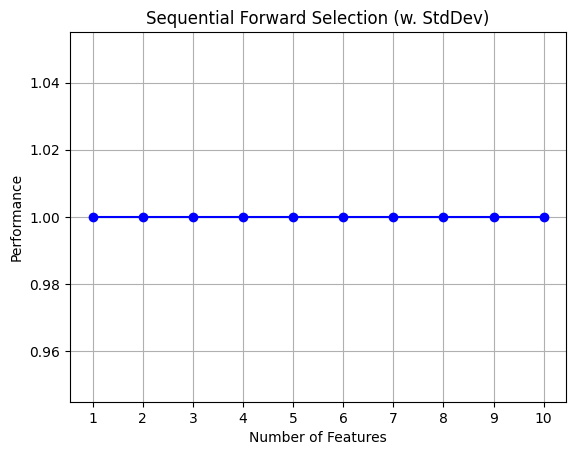

<Figure size 640x480 with 0 Axes>

In [59]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png") 

In [60]:
# Теперь график SBS.

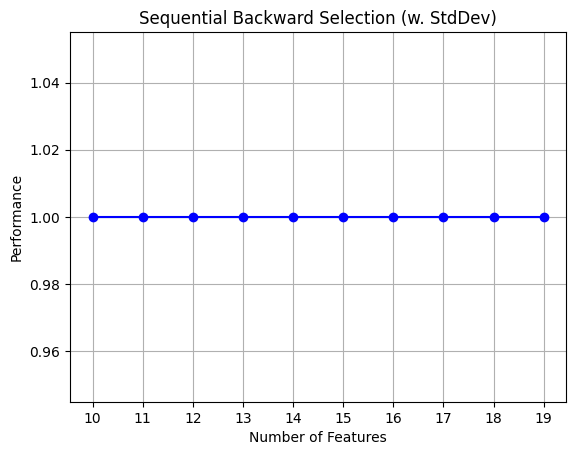

<Figure size 640x480 with 0 Axes>

In [61]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sbs.png") 

In [62]:
# Задание 2
# Создайте два списка list в Python, в которых будут храниться признаки,
# отобранные путём пересечения и объединения. Файл для пересекающихся 
# множеств назовите interc_features, для объединяющихся — union_features.

In [71]:
interc_features = list(set(top_sbs) & set(top_sfs)) # interc_features = set((top_sfs,)).intersection(set((top_sbs,))) # ваш код здесь #
interc_features

['paperless_billing_Yes',
 'online_security_Yes',
 'online_backup_Yes',
 'streaming_tv_Yes',
 'gender_Male',
 'device_protection_Yes',
 'end_date',
 'tech_support_Yes',
 'streaming_movies_Yes',
 'internet_service_Fiber optic']

In [72]:
# объединение
union_features = list(set(top_sbs) | set(top_sfs)) # union_features = set((top_sfs,)).union(set((top_sbs,)))
union_features

['paperless_billing_Yes',
 'online_backup_Yes',
 'gender_Male',
 'device_protection_Yes',
 'end_date',
 'streaming_movies_Yes',
 'online_security_Yes',
 'streaming_tv_Yes',
 'tech_support_Yes',
 'internet_service_Fiber optic']

In [69]:
union_features 

{('paperless_billing_Yes',
  'internet_service_Fiber optic',
  'online_security_Yes',
  'online_backup_Yes',
  'device_protection_Yes',
  'tech_support_Yes',
  'streaming_tv_Yes',
  'streaming_movies_Yes',
  'gender_Male',
  'end_date')}

In [75]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" # ваш код здесь
os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv('AWS_SECRET_ACCESS_KEY')

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [76]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')

In [77]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

In [78]:
experiment_id

'1'

In [80]:
with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts(FS_ASSETS) 

In [81]:
run_id

'd3d76487b931495d92447ab20054a0f0'

In [1]:
# Задание 4
# Теперь обучите две версии модели на двух наборах признаков и сравните метрики. 
# Зарегистрируйте обе модели в MLflow в экспериментах feature_selection_union и 
# feature_selection_intersection. В переменные ниже вставьте соответствующую информацию.

In [2]:
import os

import psycopg
import pandas as pd
import mlflow
from catboost import CatBoostClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [92]:
TABLE_NAME = "users_churn" # ваш код здесь #
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'churn_kruglikovAlex' # ваш код здесь #
RUN_NAME1 = "feature_selection_union"
RUN_NAME2 = "feature_selection_intersection"
REGISTRY_MODEL_NAME = 'churn_model_kruglikovAlex_b2c' # ваш код здесь #
FS_ASSETS = "../fs_assets" 

In [5]:
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split

In [23]:
df = pd.read_csv('/home/mle-user/mle_projects/mle-dvc/data/initial_data.csv')
df.head()

,id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,7020,2020-01-01,NaN,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Female,0,Yes,No,No,0
1,7021,2017-04-01,NaN,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,0
2,7022,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,1
3,7023,2016-05-01,NaN,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,No,0
4,7024,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,1


In [24]:
df = df.drop(columns=['begin_date','end_date'])
df.head()

,id,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,7020,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,0
1,7021,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0
2,7022,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,1
3,7023,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No,0
4,7024,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1


In [25]:
cat_features = df.select_dtypes(include='object')
potential_binary_features = cat_features.nunique() == 2

In [26]:
binary_cat_features = cat_features[potential_binary_features[potential_binary_features].index]
other_cat_features = cat_features[potential_binary_features[~potential_binary_features].index]
num_features = df.select_dtypes(['float'])

In [27]:
binary_cols = binary_cat_features.columns.tolist()
non_binary_cat_cols = other_cat_features.columns.tolist()
num_cols = num_features.columns.tolist()

In [29]:
binary_cols.append('senior_citizen')

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [35]:
len(binary_cols)+len(non_binary_cat_cols)+len(num_cols)

17

In [36]:
preprocessor = ColumnTransformer(
    [
        ('binary', OneHotEncoder(drop='if_binary'), binary_cols),
        ('cat', CatBoostEncoder(return_df=False), non_binary_cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [37]:
X_transf = preprocessor.fit_transform(df, df['target'])

In [40]:
X = pd.DataFrame(X_transf, columns=preprocessor.get_feature_names_out())
X.head()

,paperless_billing_Yes,internet_service_Fiber optic,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,gender_Male,partner_Yes,dependents_Yes,multiple_lines_Yes,senior_citizen_1,type,payment_method,monthly_charges,total_charges
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.265422,0.265422,-1.166156,-0.998372
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.265422,0.265422,-0.264154,-0.177284
2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.132711,0.132711,-0.367335,-0.963801
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.132711,0.265422,-0.751768,-0.198808
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.421807,0.132711,0.193503,-0.944594


In [41]:
X.shape

(7019, 17)

In [43]:
X.columns

Index(['paperless_billing_Yes', 'internet_service_Fiber optic',
       'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes',
       'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes',
       'gender_Male', 'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes',
       'senior_citizen_1', 'type', 'payment_method', 'monthly_charges',
       'total_charges'],
      dtype='object')

In [44]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, df['target'], test_size=0.2, random_state=42)

In [46]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf

RandomForestClassifier(n_estimators=300, random_state=42)

In [47]:
# Инициализация Sequential Feature Selector для backward selection
sfs = SFS(rf,
          k_features=10, 
          forward=True, 
          floating=False, 
          scoring='roc_auc', 
          cv=4, 
          n_jobs=-1)
sfs

SequentialFeatureSelector(cv=4,
                          estimator=RandomForestClassifier(n_estimators=300,
                                                           random_state=42),
                          k_features=10, n_jobs=-1, scoring='roc_auc')

In [48]:
sfs_features = sfs.fit(X_train, y_train)

/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73

In [50]:
# Выбор признаков с помощью SFS
top_sfs = sfs.k_feature_names_ # ваш код здесь #
top_sfs

('paperless_billing_Yes',
 'internet_service_Fiber optic',
 'online_security_Yes',
 'online_backup_Yes',
 'tech_support_Yes',
 'gender_Male',
 'type',
 'payment_method',
 'monthly_charges',
 'total_charges')

In [51]:
# Инициализация Sequential Feature Selector для backward selection
sbs = SFS(rf,
          k_features=10, 
          forward=False, 
          floating=False, 
          scoring='roc_auc', 
          cv=4, 
          n_jobs=-1)
sbs

SequentialFeatureSelector(cv=4,
                          estimator=RandomForestClassifier(n_estimators=300,
                                                           random_state=42),
                          forward=False, k_features=10, n_jobs=-1,
                          scoring='roc_auc')

In [ ]:
sbs_features = sbs.fit(X_train, y_train)

/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73

In [53]:
# Выбор признаков с помощью SFS
top_sbs = sbs.k_feature_names_ # ваш код здесь #
top_sbs

('paperless_billing_Yes',
 'internet_service_Fiber optic',
 'online_security_Yes',
 'tech_support_Yes',
 'streaming_movies_Yes',
 'gender_Male',
 'type',
 'payment_method',
 'monthly_charges',
 'total_charges')

In [54]:
print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)


Sequential Forward Selection (k=10)
CV Score:
0.8310778643669217

Sequential Backward Selection
CV Score:
0.8315763126777841


In [55]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 

In [56]:
sfs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(13,)","[0.6945706391257556, 0.6992018140589569, 0.672...",0.691936,"(type,)",0.018443,0.011505,0.006643
2,"(13, 15)","[0.7667711006705854, 0.767072238419177, 0.7431...",0.759401,"(type, monthly_charges)",0.015612,0.009739,0.005623
3,"(13, 15, 16)","[0.8135943579766536, 0.8103492063492064, 0.786...",0.804129,"(type, monthly_charges, total_charges)",0.017243,0.010757,0.00621
4,"(13, 14, 15, 16)","[0.8148814574882027, 0.8100213799805637, 0.798...",0.811669,"(type, payment_method, monthly_charges, total_...",0.014535,0.009067,0.005235
5,"(0, 13, 14, 15, 16)","[0.824280517840881, 0.8142831227729187, 0.8042...",0.817462,"(paperless_billing_Yes, type, payment_method, ...",0.014443,0.00901,0.005202
6,"(0, 2, 13, 14, 15, 16)","[0.8299541042304827, 0.817706511175899, 0.8107...",0.823345,"(paperless_billing_Yes, online_security_Yes, t...",0.015354,0.009578,0.00553
7,"(0, 1, 2, 13, 14, 15, 16)","[0.8376249586058448, 0.8192523485584711, 0.809...",0.825297,"(paperless_billing_Yes, internet_service_Fiber...",0.01804,0.011254,0.006498
8,"(0, 1, 2, 8, 13, 14, 15, 16)","[0.8402832395065817, 0.8206284418529316, 0.810...",0.827565,"(paperless_billing_Yes, internet_service_Fiber...",0.020306,0.012668,0.007314
9,"(0, 1, 2, 3, 8, 13, 14, 15, 16)","[0.8414060559648979, 0.8213501781665046, 0.812...",0.829099,"(paperless_billing_Yes, internet_service_Fiber...",0.02019,0.012595,0.007272
10,"(0, 1, 2, 3, 5, 8, 13, 14, 15, 16)","[0.8439285122940641, 0.8232795594428248, 0.813...",0.831078,"(paperless_billing_Yes, internet_service_Fiber...",0.02088,0.013026,0.007521


In [57]:
sbs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
17,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.843037244391092, 0.8275840621963071, 0.8192...",0.832776,"(paperless_billing_Yes, internet_service_Fiber...",0.015749,0.009825,0.005672
16,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[0.8457472679857605, 0.828, 0.818293488824101,...",0.834328,"(paperless_billing_Yes, internet_service_Fiber...",0.01875,0.011697,0.006753
15,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15...","[0.8468571487705937, 0.8279390994493037, 0.820...",0.834689,"(paperless_billing_Yes, internet_service_Fiber...",0.017041,0.010631,0.006138
14,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 13, 14, 15, 16)","[0.8473926856527859, 0.8282202785876255, 0.822...",0.835578,"(paperless_billing_Yes, internet_service_Fiber...",0.017065,0.010646,0.006146
13,"(0, 1, 2, 3, 4, 5, 7, 8, 9, 13, 14, 15, 16)","[0.8490471582912493, 0.8270903790087464, 0.819...",0.834718,"(paperless_billing_Yes, internet_service_Fiber...",0.019295,0.012037,0.006949
12,"(0, 1, 2, 3, 5, 7, 8, 9, 13, 14, 15, 16)","[0.8471520821260038, 0.8267223841917719, 0.819...",0.834035,"(paperless_billing_Yes, internet_service_Fiber...",0.017977,0.011215,0.006475
11,"(0, 1, 2, 5, 7, 8, 9, 13, 14, 15, 16)","[0.8480420564616277, 0.8267457078069322, 0.820...",0.834197,"(paperless_billing_Yes, internet_service_Fiber...",0.017683,0.011032,0.006369
10,"(0, 1, 2, 5, 7, 8, 13, 14, 15, 16)","[0.8436672116897095, 0.8237551020408165, 0.816...",0.831576,"(paperless_billing_Yes, internet_service_Fiber...",0.018962,0.011829,0.00683


In [58]:
# save on disk
os.makedirs(FS_ASSETS, exist_ok=True)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv") 

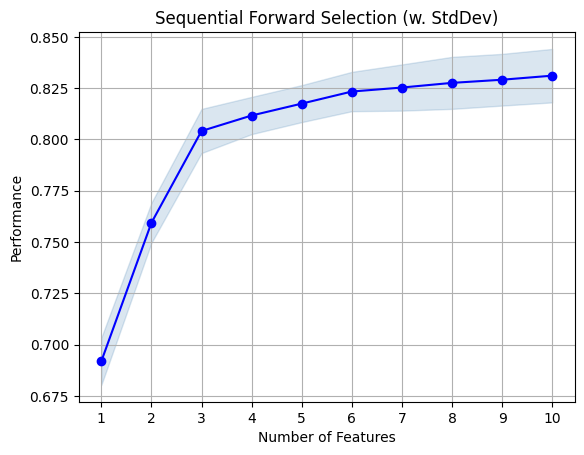

<Figure size 640x480 with 0 Axes>

In [61]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png") 

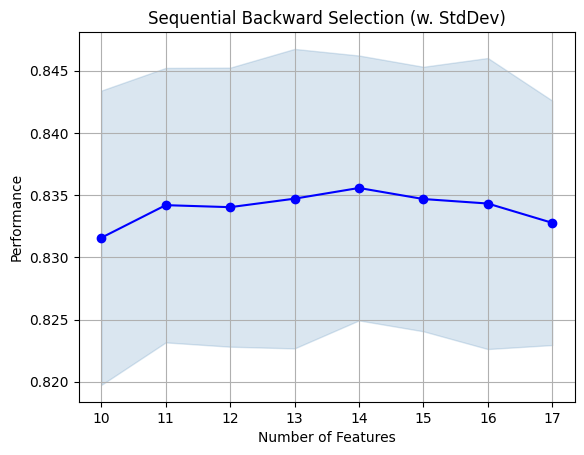

<Figure size 640x480 with 0 Axes>

In [62]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sbs.png") 

In [63]:
interc_features = list(set(top_sbs) & set(top_sfs)) # ваш код здесь #
union_features = list(set(top_sbs) | set(top_sfs)) # ваш код здесь #

In [64]:
interc_features

['internet_service_Fiber optic',
 'online_security_Yes',
 'tech_support_Yes',
 'paperless_billing_Yes',
 'payment_method',
 'total_charges',
 'gender_Male',
 'type',
 'monthly_charges']

In [65]:
union_features

['online_security_Yes',
 'total_charges',
 'gender_Male',
 'internet_service_Fiber optic',
 'tech_support_Yes',
 'paperless_billing_Yes',
 'online_backup_Yes',
 'payment_method',
 'streaming_movies_Yes',
 'type',
 'monthly_charges']

In [71]:
model_interc = CatBoostClassifier()

In [72]:
X_train[interc_features]

,internet_service_Fiber optic,online_security_Yes,tech_support_Yes,paperless_billing_Yes,payment_method,total_charges,gender_Male,type,monthly_charges
1452,1.0,0.0,0.0,1.0,0.473575,-0.333916,0.0,0.431043,1.168730
3269,0.0,1.0,1.0,0.0,0.137051,-0.383102,1.0,0.107902,-0.255833
5267,0.0,0.0,0.0,0.0,0.451926,-0.924129,0.0,0.420764,-0.638601
1323,0.0,1.0,1.0,1.0,0.185432,-0.061559,0.0,0.102041,-0.453874
5189,0.0,1.0,1.0,0.0,0.161636,0.010057,1.0,0.023563,0.023754
...,...,...,...,...,...,...,...,...,...
3772,1.0,0.0,0.0,1.0,0.174126,-0.159843,1.0,0.432001,0.361588
5191,0.0,1.0,1.0,0.0,0.161495,-0.666784,0.0,0.420962,-0.180944
5226,1.0,0.0,1.0,1.0,0.146083,-0.249496,1.0,0.113191,0.759334
5390,0.0,1.0,1.0,0.0,0.188386,0.760832,0.0,0.024218,-0.044479


In [73]:
model_interc.fit(X_train[interc_features], y_train)

Learning rate set to 0.021523
0:	learn: 0.6781639	total: 136ms	remaining: 2m 16s
1:	learn: 0.6653576	total: 139ms	remaining: 1m 9s
2:	learn: 0.6536211	total: 142ms	remaining: 47.2s
3:	learn: 0.6416640	total: 145ms	remaining: 36.1s
4:	learn: 0.6296850	total: 148ms	remaining: 29.4s
5:	learn: 0.6191288	total: 150ms	remaining: 24.9s
6:	learn: 0.6082524	total: 153ms	remaining: 21.6s
7:	learn: 0.5983434	total: 155ms	remaining: 19.2s
8:	learn: 0.5888897	total: 157ms	remaining: 17.3s
9:	learn: 0.5796338	total: 160ms	remaining: 15.8s
10:	learn: 0.5708611	total: 164ms	remaining: 14.7s
11:	learn: 0.5637624	total: 167ms	remaining: 13.7s
12:	learn: 0.5567730	total: 169ms	remaining: 12.8s
13:	learn: 0.5500951	total: 172ms	remaining: 12.1s
14:	learn: 0.5437929	total: 174ms	remaining: 11.4s
15:	learn: 0.5379155	total: 177ms	remaining: 10.9s
16:	learn: 0.5317251	total: 179ms	remaining: 10.3s
17:	learn: 0.5260356	total: 181ms	remaining: 9.9s
18:	learn: 0.5202364	total: 191ms	remaining: 9.85s
19:	learn: 

In [82]:
y_pred = model_interc.predict(X_test)

In [83]:
from sklearn.metrics import roc_auc_score, f1_score, log_loss, recall_score, precision_score, confusion_matrix

In [84]:
# получите предсказания для тестовой выборки
y_pred_proba = model_interc.predict_proba(X_test)[:, 1] 

print('f1:', f1_score(y_test, y_pred))
print('roc_auc:', roc_auc_score(y_test, y_pred_proba))

f1: 0.5606060606060606
roc_auc: 0.8440631594574819


In [85]:
prediction = y_pred
proba = y_pred_proba

In [86]:
_, err1, _, err2 = confusion_matrix(y_test, prediction, normalize='all').ravel()
err2

0.13176638176638178

In [87]:
proba

array([0.81440773, 0.00563503, 0.88202732, ..., 0.00517415, 0.02034487,
       0.01965136])

In [88]:
# заведите словарь со всеми метриками
metrics = {}

# посчитайте метрики из модуля sklearn.metrics
# err_1 — ошибка первого рода
# err_2 — ошибка второго рода
_, err1, _, err2 = confusion_matrix(y_test, prediction, normalize='all').ravel() # ваш код здесь #
auc = roc_auc_score(y_test, proba) # ваш код здесь #
precision = precision_score(y_test, prediction) # ваш код здесь #
recall = recall_score(y_test, prediction) # ваш код здесь #
f1 = f1_score(y_test, prediction) # ваш код здесь #
logloss = log_loss(y_test, prediction) # ваш код здесь #

# запишите значения метрик в словарь
metrics["err1"] = err1
metrics["err2"] = err2
metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss

In [89]:
metrics

{'err1': 0.08048433048433049,
 'err2': 0.13176638176638178,
 'auc': 0.8440631594574819,
 'precision': 0.6208053691275168,
 'recall': 0.511049723756906,
 'f1': 0.5606060606060606,
 'logloss': 7.444914161569783}

In [90]:
# ваш код здесь

pip_requirements = "../requirements.txt" # ваш код здесь
signature = mlflow.models.infer_signature(
    X_train,
    prediction.astype(int)
)
# ваш код здесь
input_example = X_test[:10] # ваш код здесь
metadata = {'model_type': 'monthly'} # ваш код здесь

In [91]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')

In [94]:
# создаём новый эксперимент в MLflow с указанным названием 
# если эксперимент с таким именем уже существует, 
# MLflow возвращает идентификатор существующего эксперимента
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME) # ваш код здесь
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
experiment_id

'1'

In [95]:
class CatboostModelProba(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        super().__init__()
        self._model = model

    def predict(self, context, model_input):
        import numpy as np
        predictions = np.sqrt(self._model.predict(model_input))

        return predictions

In [99]:
custom_model = CatboostModelProba(model_interc) 

In [100]:
# подгружаем .env
load_dotenv()

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" # ваш код здесь
os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv('AWS_SECRET_ACCESS_KEY')

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [101]:
artifact_path = "afc"

In [104]:
with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME2) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id # ваш код здесь
    
    model_info = mlflow.pyfunc.log_model( 
        # ваш код здесь #
        python_model=custom_model,
        #cb_model=model,
        signature=signature,
        pip_requirements=pip_requirements,
        metadata = metadata,
        input_example = input_example,
        artifact_path="models",
        await_registration_for=60,
        registered_model_name=REGISTRY_MODEL_NAME,
        )

    # логируем метрики эксперимента
    # где ключи — это названия метрик, а значения — числовые значения метрик
    mlflow.log_metrics(metrics)

    # логируем файл как артефакт эксперимента — 'users_churn.csv'
    mlflow.log_artifact("/home/mle-user/mle_projects/mle-dvc/data/initial_data.csv", "dataframe")
    mlflow.log_artifacts(FS_ASSETS) 


Registered model 'churn_model_kruglikovAlex_b2c' already exists. Creating a new version of this model...
2025/07/22 22:10:04 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_kruglikovAlex_b2c, version 5
Created version '5' of model 'churn_model_kruglikovAlex_b2c'.


In [105]:
run_id

'34092cda598940809e40e1f7082ffaf9'

In [107]:
RUN_NAME2
REGISTRY_MODEL_NAME

'churn_model_kruglikovAlex_b2c'

In [108]:
client = mlflow.MlflowClient()
model_metadata = client.get_latest_versions(REGISTRY_MODEL_NAME, stages=["None"])
latest_model_version = model_metadata[0].version
latest_model_version

'5'

In [109]:
model_union = CatBoostClassifier()

In [110]:
X_train[union_features]

,online_security_Yes,total_charges,gender_Male,internet_service_Fiber optic,tech_support_Yes,paperless_billing_Yes,online_backup_Yes,payment_method,streaming_movies_Yes,type,monthly_charges
1452,0.0,-0.333916,0.0,1.0,0.0,1.0,1.0,0.473575,1.0,0.431043,1.168730
3269,1.0,-0.383102,1.0,0.0,1.0,0.0,0.0,0.137051,0.0,0.107902,-0.255833
5267,0.0,-0.924129,0.0,0.0,0.0,0.0,0.0,0.451926,1.0,0.420764,-0.638601
1323,1.0,-0.061559,0.0,0.0,1.0,1.0,1.0,0.185432,0.0,0.102041,-0.453874
5189,1.0,0.010057,1.0,0.0,1.0,0.0,1.0,0.161636,0.0,0.023563,0.023754
...,...,...,...,...,...,...,...,...,...,...,...
3772,0.0,-0.159843,1.0,1.0,0.0,1.0,0.0,0.174126,0.0,0.432001,0.361588
5191,1.0,-0.666784,0.0,0.0,1.0,0.0,1.0,0.161495,0.0,0.420962,-0.180944
5226,0.0,-0.249496,1.0,1.0,1.0,1.0,0.0,0.146083,1.0,0.113191,0.759334
5390,1.0,0.760832,0.0,0.0,1.0,0.0,1.0,0.188386,0.0,0.024218,-0.044479


In [112]:
model_union.fit(X_train[union_features], y_train)

Learning rate set to 0.021523
0:	learn: 0.6790552	total: 3.08ms	remaining: 3.08s
1:	learn: 0.6656136	total: 5.73ms	remaining: 2.86s
2:	learn: 0.6514660	total: 8.36ms	remaining: 2.78s
3:	learn: 0.6389196	total: 11.1ms	remaining: 2.75s
4:	learn: 0.6274053	total: 13.7ms	remaining: 2.73s
5:	learn: 0.6170835	total: 17.3ms	remaining: 2.87s
6:	learn: 0.6076549	total: 21.3ms	remaining: 3.01s
7:	learn: 0.5978306	total: 24ms	remaining: 2.98s
8:	learn: 0.5891529	total: 27ms	remaining: 2.97s
9:	learn: 0.5811585	total: 29.6ms	remaining: 2.93s
10:	learn: 0.5725654	total: 32.3ms	remaining: 2.9s
11:	learn: 0.5650724	total: 35.6ms	remaining: 2.93s
12:	learn: 0.5594479	total: 39.2ms	remaining: 2.98s
13:	learn: 0.5520146	total: 43.6ms	remaining: 3.07s
14:	learn: 0.5458619	total: 48.9ms	remaining: 3.21s
15:	learn: 0.5399525	total: 51.8ms	remaining: 3.19s
16:	learn: 0.5341225	total: 54.8ms	remaining: 3.17s
17:	learn: 0.5289266	total: 58ms	remaining: 3.16s
18:	learn: 0.5234396	total: 61ms	remaining: 3.15s
1

In [113]:
y_pred = model_union.predict(X_test)

In [114]:
# получите предсказания для тестовой выборки
y_pred_proba = model_union.predict_proba(X_test)[:, 1] 

print('f1:', f1_score(y_test, y_pred))
print('roc_auc:', roc_auc_score(y_test, y_pred_proba))

f1: 0.572289156626506
roc_auc: 0.8450308056118175


In [115]:
prediction = y_pred
proba = y_pred_proba

In [116]:
_, err1, _, err2 = confusion_matrix(y_test, prediction, normalize='all').ravel()
err2

0.13532763532763534

In [117]:
proba

array([0.85657818, 0.00596062, 0.88335276, ..., 0.0036575 , 0.02539305,
       0.0154996 ])

In [118]:
# заведите словарь со всеми метриками
metrics = {}

# посчитайте метрики из модуля sklearn.metrics
# err_1 — ошибка первого рода
# err_2 — ошибка второго рода
_, err1, _, err2 = confusion_matrix(y_test, prediction, normalize='all').ravel() # ваш код здесь #
auc = roc_auc_score(y_test, proba) # ваш код здесь #
precision = precision_score(y_test, prediction) # ваш код здесь #
recall = recall_score(y_test, prediction) # ваш код здесь #
f1 = f1_score(y_test, prediction) # ваш код здесь #
logloss = log_loss(y_test, prediction) # ваш код здесь #

# запишите значения метрик в словарь
metrics["err1"] = err1
metrics["err2"] = err2
metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss

In [119]:
metrics

{'err1': 0.07977207977207977,
 'err2': 0.13532763532763534,
 'auc': 0.8450308056118175,
 'precision': 0.6291390728476821,
 'recall': 0.5248618784530387,
 'f1': 0.572289156626506,
 'logloss': 7.290881454778684}

In [120]:
# ваш код здесь

pip_requirements = "../requirements.txt" # ваш код здесь
signature = mlflow.models.infer_signature(
    X_train,
    prediction.astype(int)
)
# ваш код здесь
input_example = X_test[:10] # ваш код здесь
metadata = {'model_type': 'monthly'} # ваш код здесь

In [121]:
# создаём новый эксперимент в MLflow с указанным названием 
# если эксперимент с таким именем уже существует, 
# MLflow возвращает идентификатор существующего эксперимента
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME) # ваш код здесь
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
experiment_id

'1'

In [122]:
custom_model = CatboostModelProba(model_union) 

In [123]:
with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME1) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id # ваш код здесь
    
    model_info = mlflow.pyfunc.log_model( 
        # ваш код здесь #
        python_model=custom_model,
        #cb_model=model,
        signature=signature,
        pip_requirements=pip_requirements,
        metadata = metadata,
        input_example = input_example,
        artifact_path="models",
        await_registration_for=60,
        registered_model_name=REGISTRY_MODEL_NAME,
        )

    # логируем метрики эксперимента
    # где ключи — это названия метрик, а значения — числовые значения метрик
    mlflow.log_metrics(metrics)

    # логируем файл как артефакт эксперимента — 'users_churn.csv'
    mlflow.log_artifact("/home/mle-user/mle_projects/mle-dvc/data/initial_data.csv", "dataframe")
    mlflow.log_artifacts(FS_ASSETS)

Registered model 'churn_model_kruglikovAlex_b2c' already exists. Creating a new version of this model...
2025/07/22 22:24:28 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_kruglikovAlex_b2c, version 6
Created version '6' of model 'churn_model_kruglikovAlex_b2c'.


In [124]:
run_id

'c5ac9e5193f84f26842348e5dc6efc81'

In [125]:
RUN_NAME1

'feature_selection_union'

In [126]:
client = mlflow.MlflowClient()
model_metadata = client.get_latest_versions(REGISTRY_MODEL_NAME, stages=["None"])
latest_model_version = model_metadata[0].version
latest_model_version

'6'